In [55]:
!pip install pandas
import numpy as np
import pandas as pd
import t3_utils as t3
import time 
from ast import literal_eval
import matplotlib.pyplot as plt
import importlib


[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [53]:
# reload module in case any functions have changed, this way all the data does not get lost
importlib.reload(t3)

<module 't3_utils' from 'C:\\Users\\Daniel\\Documents\\GitHub\\MMSR-Group-C\\3\\t3_utils.py'>

In [4]:
# change the file path here
file_path_base = r"C:\\Users\\Daniel\\Documents\\mmsr_data\\"
file_path_info = file_path_base + "id_information_mmsr.tsv" 
file_path_word2vec = file_path_base + "id_lyrics_word2vec_mmsr.tsv"
file_path_tfidf = file_path_base + "id_lyrics_tf-idf_mmsr.tsv"
file_path_bert = file_path_base + "id_lyrics_bert_mmsr.tsv"

file_path_genre = file_path_base + "id_genres_mmsr.tsv"
file_path_musicnn = file_path_base + "id_musicnn_mmsr.tsv"
file_path_mfcc_bow = file_path_base + "id_mfcc_bow_mmsr.tsv"
file_path_ivec_256 = file_path_base + "id_ivec256_mmsr.tsv"
file_path_logfluc = file_path_base + "id_blf_logfluc_mmsr.tsv"

file_path_incp = file_path_base  + "id_incp_mmsr.tsv"
file_path_vgg19 = file_path_base + "id_vgg19_mmsr.tsv"
file_path_resnet = file_path_base + "id_resnet_mmsr.tsv"
file_path_url = file_path_base + "id_url_mmsr.tsv"

df_info = pd.read_table(file_path_info)

# text
df_word2vec = pd.read_table(file_path_word2vec)
df_tfidf = pd.read_table(file_path_tfidf)
df_bert = pd.read_table(file_path_bert)

# audio
df_genre = pd.read_table(file_path_genre)
df_musicnn = pd.read_table(file_path_musicnn)
df_mfcc_bow = pd.read_table(file_path_mfcc_bow)
df_ivec_256 = pd.read_table(file_path_ivec_256)
df_logfluc = pd.read_table(file_path_logfluc)

# video
df_incp = pd.read_table(file_path_incp)
df_vgg19 = pd.read_table(file_path_vgg19)
df_resnet = pd.read_table(file_path_resnet)
df_url = pd.read_table(file_path_url)

df_genre["genre"] = df_genre["genre"].apply(literal_eval) # convert string into array

In [5]:
# getting the unique genres
genres = df_genre.explode("genre")["genre"].values
unique_genres = np.unique(genres)
len(unique_genres)

1112

In [6]:
# Video-based(cos-sim, Resnet)
t3.song_retrieval(df_info, df_resnet, "As Long as You Love Me","Justin Bieber", 10, t3.cos_sim, filter = ["id", "artist", "song", "sim"])

,id,artist,song,sim
980,5pMLWikvbUlxbw3C,The Killers,The Man,0.952437
1255,7bbCXbz5k2bdp6Kx,Ed Sheeran,Shape of You,0.946972
5942,anGHLhCNm6LMQyJS,Fredo,BMT,0.941186
2310,Du6H3gaehf6JfGWR,Taylor Swift,I Knew You Were Trouble.,0.940473
9891,ydS4NguMgrD2NgdG,Oasis,Falling Down,0.936767
960,5idcPLZ9jjchsnJE,Walking On Cars,Don't Mind Me,0.936165
8044,nSIr2ANHkjuzor6x,Enter Shikari,Anaesthetist,0.934372
2383,EPqmOSE7NVZ7dHWz,Royal Tusk,Aftermath,0.934292
1538,99TGOj3j5GlKzzN6,50 Cent,When It Rains It Pours,0.932984
9154,u7sN5CwHeZAirKE0,Sebastian Yatra,Cristina,0.932632


In [18]:
# prepare early fusion feature
# normalizes and joins both features
df_normalized_bert = t3.normalize_frame(df_bert)
df_normalized_musicnn = t3.normalize_frame(df_musicnn)
df_early_fusion = pd.merge(df_normalized_bert, df_normalized_musicnn, on="id", how="outer")

In [33]:
# Early Fusion(cos-sim, bert, mfcc bow)
t3.song_retrieval(df_info, df_early_fusion, "As Long as You Love Me","Justin Bieber", 10, t3.cos_sim)

,id,artist,song,album_name,sim
3088,IpJ1aktgYIvbyqQf,Robyn,Just Another Girlfriend,Robyn Is Here,0.982431
7596,ksziW8IQD3GYKkcA,Warlock,Für Immer,Triumph And Agony,0.981990
9477,w64KwSB7npnE8hb2,Feist,Inside and Out,Let It Die,0.981675
1474,8nyPt8gB1K8g5FNv,Bon Jovi,Always,Cross Road,0.981131
9616,wxC03mQZsTdIlLfZ,Barry White,Never Never Gonna Give Ya Up,The Complete 20th Century Records Singles (197...,0.981053
2518,FGJmF8RWJyZ4jUg1,Ariana Grande,Right There,Yours Truly,0.980723
6809,g5Y3fz7C9EnMXdMA,Lana Del Rey,Blue Jeans (Gesaffelstein Remix),Blue Jeans Remixes,0.980599
2155,CxYSBn9r5KGcU1UA,Zayn,Let Me,Icarus Falls,0.980534
8987,tBO9u8VG5NNB3s0z,Faith No More,Edge of the World,The Real Thing,0.980430
8450,ptSQMoK9d8CydnHP,Phoenix,Chloroform,Bankrupt!,0.980294


In [14]:
# here we prepare our dataset before putting it in the pipeline
# computes the idcg value for each song beforehand
df_genre["idcg_value"] = df_genre.apply(lambda x: t3.idcg(x, df_genre), axis=1)
df_genre

,id,genre,idcg_value
0,01Yfj2T3YTwJ1Yfy,"[rock, christian rock]",4.031238
1,01gyRHLquwXDlhkO,"[hip hop, rap, grindcore, death metal]",3.029040
2,01rMxQv6vhyE1oQX,"[rock, pop punk]",3.692660
3,02RGE9FNH65RtMS7,"[trance, techno, progressive trance]",1.941748
4,02ZnlCGZEbkfCDxo,"[pop, italian pop, latin, europop, ambient, po...",2.335130
...,...,...,...
10089,zyzILCQvVeUFIINi,"[rock, pop, indie rock, folk rock, new wave, m...",3.076931
10090,zzgS4ZqyswamEWNj,"[pop, rock, teen pop, soundtrack, singer songw...",3.064803
10091,zzoFYDMlqU1X2zz1,"[jazz, jazz fusion]",3.330893
10092,zzpkRCGA5ud8q4mv,"[soul, blues, r b, blues rock, southern soul, ...",2.559602


In [15]:
# computes the number of relevant songs in the dataset for each song (needed to compute recall)
df_genre["rel_count"] = df_genre["genre"].apply(lambda genre: t3.get_rel_song_count(genre, df_genre["genre"]))
df_genre

,id,genre,idcg_value,rel_count
0,01Yfj2T3YTwJ1Yfy,"[rock, christian rock]",4.031238,4988
1,01gyRHLquwXDlhkO,"[hip hop, rap, grindcore, death metal]",3.029040,1209
2,01rMxQv6vhyE1oQX,"[rock, pop punk]",3.692660,5073
3,02RGE9FNH65RtMS7,"[trance, techno, progressive trance]",1.941748,345
4,02ZnlCGZEbkfCDxo,"[pop, italian pop, latin, europop, ambient, po...",2.335130,4942
...,...,...,...,...
10089,zyzILCQvVeUFIINi,"[rock, pop, indie rock, folk rock, new wave, m...",3.076931,7080
10090,zzgS4ZqyswamEWNj,"[pop, rock, teen pop, soundtrack, singer songw...",3.064803,6968
10091,zzoFYDMlqU1X2zz1,"[jazz, jazz fusion]",3.330893,634
10092,zzpkRCGA5ud8q4mv,"[soul, blues, r b, blues rock, southern soul, ...",2.559602,6106


In [16]:
df_song_data = pd.merge(df_info, df_genre, on = "id")
df_song_data

,id,artist,song,album_name,genre,idcg_value,rel_count
0,01Yfj2T3YTwJ1Yfy,We As Human,Take The Bullets Away (feat. Lacey Sturm),We As Human,"[rock, christian rock]",4.031238,4988
1,01gyRHLquwXDlhkO,The Notorious B.I.G.,Somebody's Gotta Die,Life After Death (Remastered Edition),"[hip hop, rap, grindcore, death metal]",3.029040,1209
2,01rMxQv6vhyE1oQX,Against the Current,Chasing Ghosts,In Our Bones,"[rock, pop punk]",3.692660,5073
3,02RGE9FNH65RtMS7,Barthezz,Infected,Trance - The Early Years (1997-2002),"[trance, techno, progressive trance]",1.941748,345
4,02ZnlCGZEbkfCDxo,Laura Pausini,Tra Te E Il Mare,The Best of Laura Pausini - E Ritorno Da Te,"[pop, italian pop, latin, europop, ambient, po...",2.335130,4942
...,...,...,...,...,...,...,...
10089,zyzILCQvVeUFIINi,Crowded House,When You Come,Temple Of Low Men,"[rock, pop, indie rock, folk rock, new wave, m...",3.076931,7080
10090,zzgS4ZqyswamEWNj,Britney Spears,My Only Wish (This Year),Platinum Christmas,"[pop, rock, teen pop, soundtrack, singer songw...",3.064803,6968
10091,zzoFYDMlqU1X2zz1,Thundercat,DUI,Drunk,"[jazz, jazz fusion]",3.330893,634
10092,zzpkRCGA5ud8q4mv,Otis Redding,Rock Me Baby,Otis Blue,"[soul, blues, r b, blues rock, southern soul, ...",2.559602,6106


nearly half
random baseline
Avg precision: 0.4451753516940706
Avg recall: 0.001004776699253307
Avg ndcg: 0.13770008017146068
Avg genre diversity: 5.0632689496483625
genre coverage: 1.0


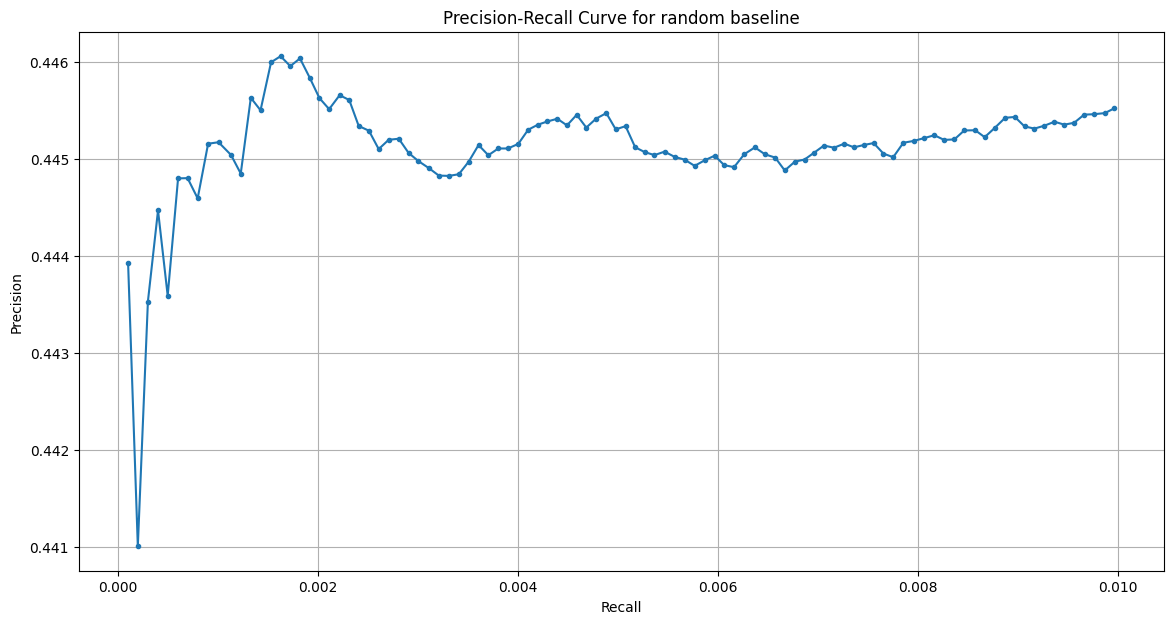

nearly half
word2vec euc-sim
Avg precision: 0.5023182088369331
Avg recall: 0.0015922490167691076
Avg ndcg: 0.17779734634943692
Avg genre diversity: 4.83642443253612
genre coverage: 0.9334532374100719


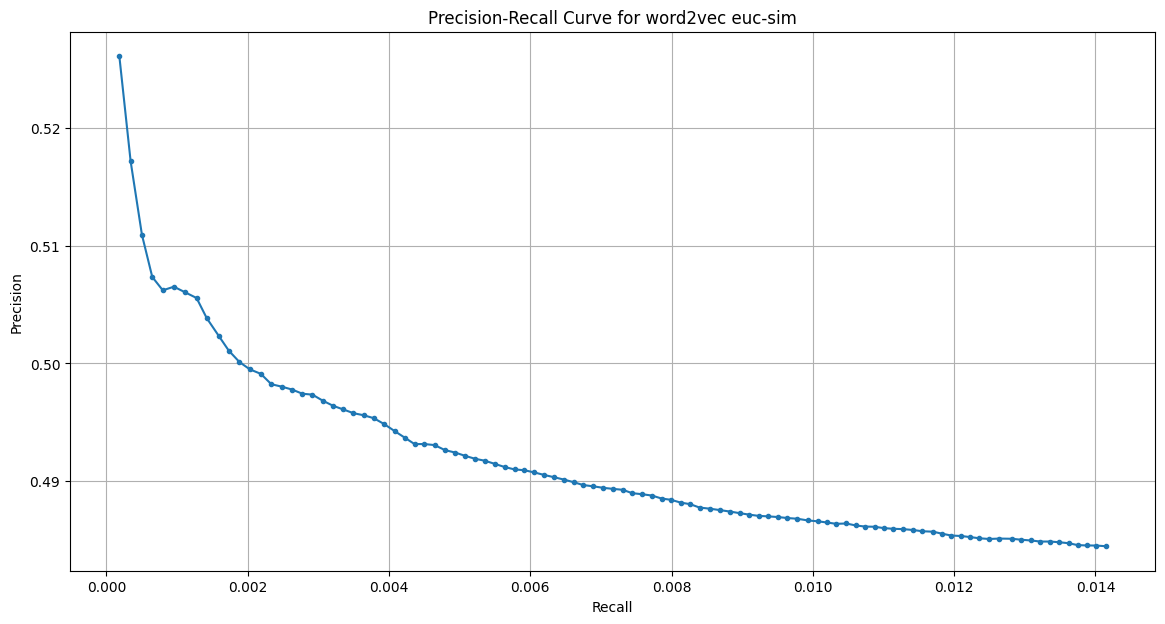

nearly half
tfidf cos-sim
Avg precision: 0.5109867247870016
Avg recall: 0.001343292094559057
Avg ndcg: 0.17149983044698994
Avg genre diversity: 4.972622666204345
genre coverage: 0.9811151079136691


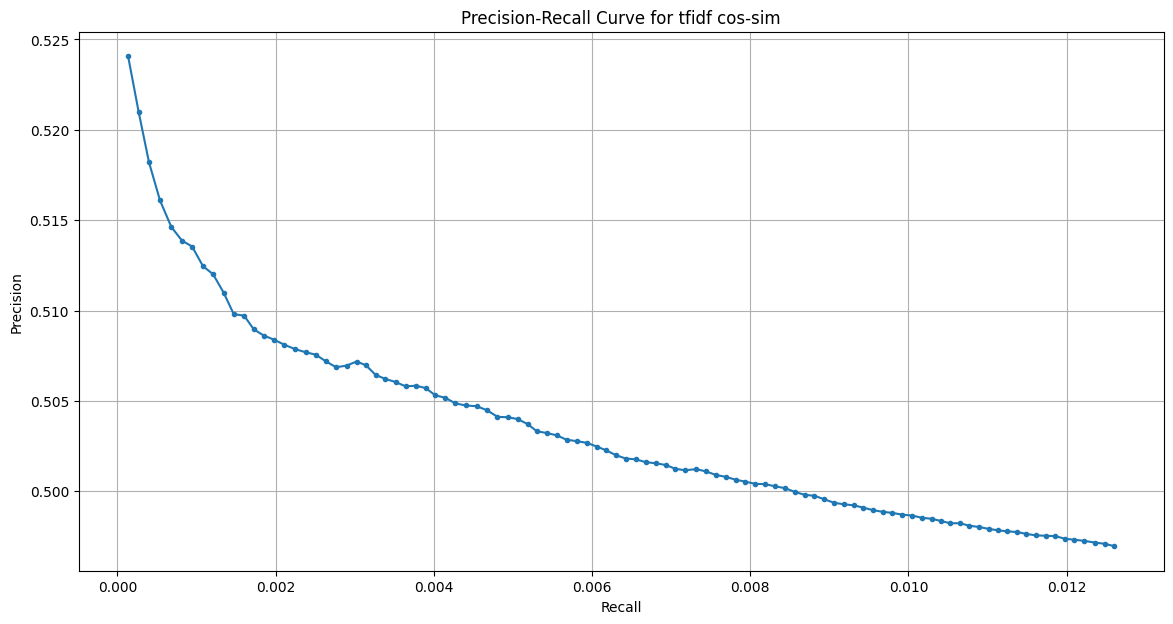

nearly half
bert cos-sim
Avg precision: 0.5522785813354479
Avg recall: 0.0018547120289303374
Avg ndcg: 0.20183773246548498
Avg genre diversity: 4.8868134942149375
genre coverage: 0.9127697841726619


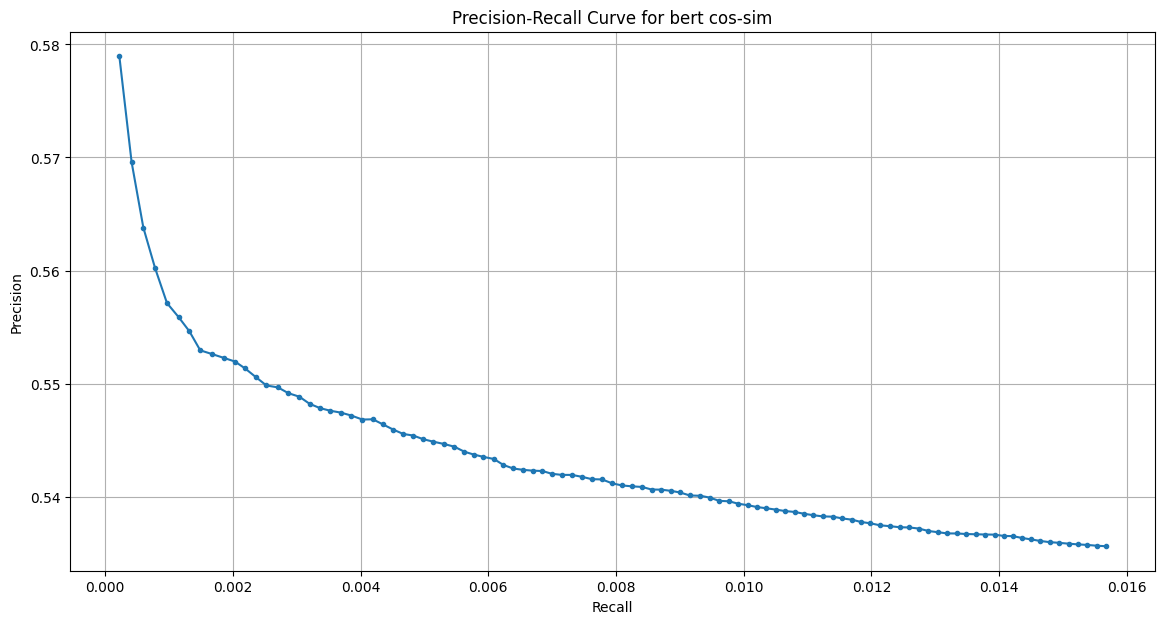

nearly half
mfcc_bow cos-sim
Avg precision: 0.5885476520705374
Avg recall: 0.0017947373024133132
Avg ndcg: 0.22569410026163622
Avg genre diversity: 4.7436668295826
genre coverage: 0.9811151079136691


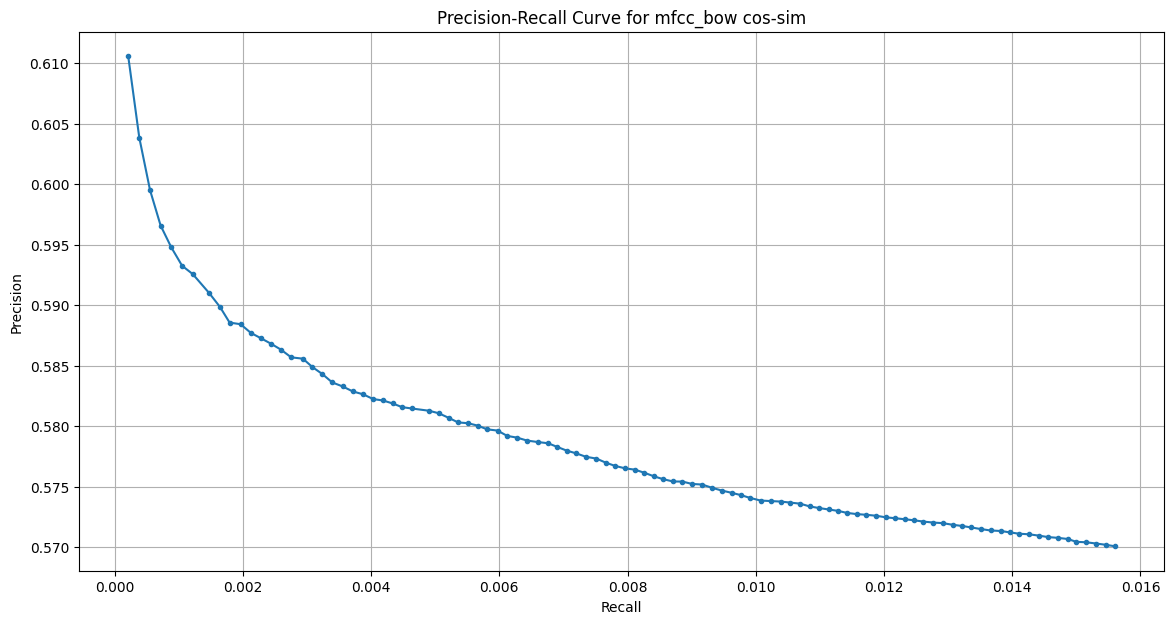

nearly half
musicnn cos-sim
Avg precision: 0.6240043590251597
Avg recall: 0.0019679607283780453
Avg ndcg: 0.24283269583851352
Avg genre diversity: 4.713777377273991
genre coverage: 0.9973021582733813


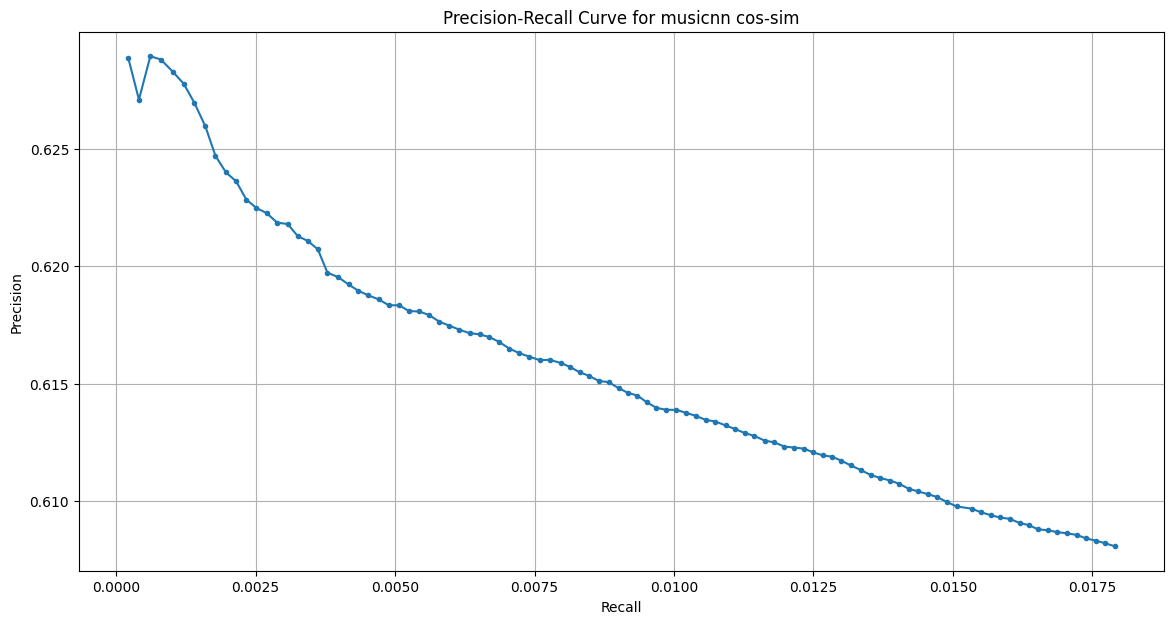

nearly half
ivec_256 cos-sim
Avg precision: 0.5656231424608696
Avg recall: 0.0017221895977655155
Avg ndcg: 0.2183574640258898
Avg genre diversity: 4.90501948427141
genre coverage: 0.9991007194244604


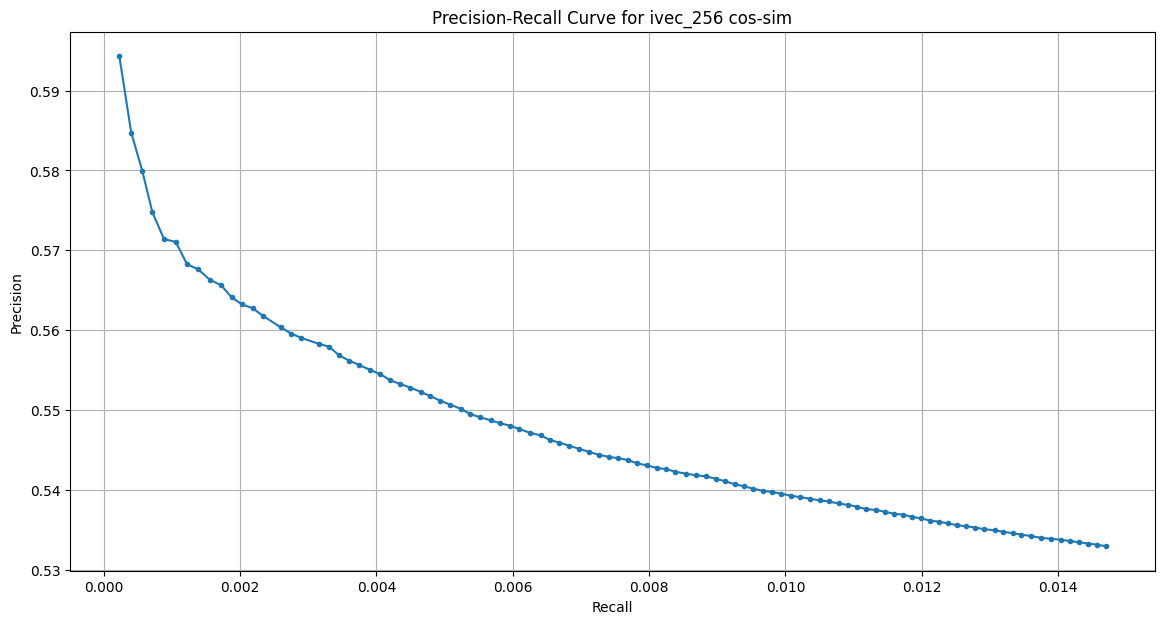

nearly half
logfluc cos-sim
Avg precision: 0.508351495938188
Avg recall: 0.0014227315651069927
Avg ndcg: 0.1817986581942194
Avg genre diversity: 4.920141801555555
genre coverage: 0.9487410071942446


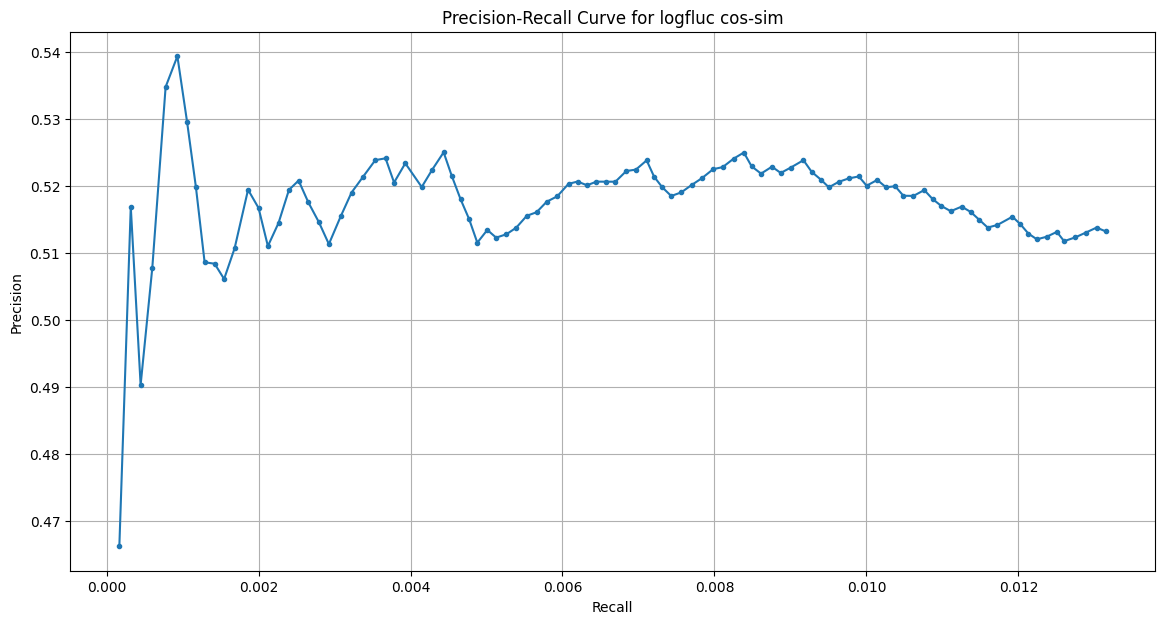

In [ ]:
# Warning: running this can take a long time
# Here we run the pipeline for every system and also print the respective precision recall curve
st = time.time()
k = 10
retr_systems = [("random baseline",df_song_data, t3.cos_sim), ("word2vec euc-sim", df_word2vec, t3.euc_sim), 
                ("tfidf cos-sim", df_tfidf, t3.cos_sim), ("bert cos-sim", df_bert, t3.cos_sim), 
                ("mfcc_bow cos-sim", df_mfcc_bow, t3.cos_sim), ("musicnn cos-sim", df_musicnn, t3.cos_sim), 
                ("ivec_256 cos-sim", df_ivec_256, t3.cos_sim), ("logfluc cos-sim", df_logfluc, t3.cos_sim),
               ("resnet cos-sim", df_resnet, t3.cos_sim), ("early fusion cos-sim", df_early_fusion, t3.cos_sim)]

retr_systems_columns = ["Avg precision", "Avg recall", "Avg ndcg", "Avg genre diversity", "Genre coverage"]
retr_systems_index = [tupl[0] for tupl in retr_systems]

df_metrics = pd.DataFrame(columns=retr_systems_columns, index = retr_systems_index)

for system in retr_systems:
    index, feature_set, sim_func = system
    metrics = t3.evaluation_pipeline(df_song_data, feature_set, sim_func, k, df_song_data.equals(feature_set), None)
    df_metrics.loc[index] = metrics[2:]
    print(index)
    print("Avg precision:", metrics[2])
    print("Avg recall:", metrics[3])
    print("Avg ndcg:", metrics[4])
    print("Avg genre diversity:", metrics[5])
    print("genre coverage:", metrics[6])
    plt.figure(figsize=(14, 7))
    plt.plot(metrics[1], metrics[0], marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {index}')
    plt.grid(True)
    plt.show()

# separate late fusion calc because i am lazy and bad at python
index = "late fusion cos-sim"
metrics = t3.evaluation_pipeline(df_song_data, df_tfidf, t3.cos_sim, k, False, df_logfluc)
df_metrics.loc[index] = metrics[2:]
print(index)
print("Avg precision:", metrics[2])
print("Avg recall:", metrics[3])
print("Avg ndcg:", metrics[4])
print("Avg genre diversity:", metrics[5])
print("genre coverage:", metrics[6])
plt.figure(figsize=(14, 7))
plt.plot(metrics[1], metrics[0], marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve for {index}')
plt.grid(True)
plt.show()
     
print("Execution time(min):", (time.time()-st)/60)
df_metrics

In [ ]:
# below this cell the evaluation pipeline for every retrieval system is run individually, so it can be ignored

In [ ]:
st = time.time()
metrics_random = t3.evaluation_pipeline(df_song_data, df_song_data, t3.cos_sim, 10, True)
print("random")
print("Avg precision:", metrics_random[2])
print("Avg recall:", metrics_random[3])
print("Avg ndcg:", metrics_random[4])
print("Avg genre diversity:", metrics_random[5])
print("genre coverage:", metrics_random[6])
print("Execution time(min):", (time.time()-st)/60)

In [ ]:
st = time.time()
metrics_word2vec = t3.evaluation_pipeline(df_song_data, df_word2vec, t3.euc_sim, 10)
print("word2vec")
print("Avg precision:", metrics_word2vec[2])
print("Avg recall:", metrics_word2vec[3])
print("Avg ndcg:", metrics_word2vec[4])
print("Avg genre diversity:", metrics_word2vec[5])
print("genre coverage:", metrics_word2vec[6])
print("Execution time(min):", (time.time()-st)/60)

In [ ]:
st = time.time()
metrics_tfidf = t3.evaluation_pipeline(df_song_data, df_tfidf, t3.cos_sim, 10)
print("tfidf")
print("Avg precision:", metrics_tfidf[2])
print("Avg recall:", metrics_tfidf[3])
print("Avg ndcg:", metrics_tfidf[4])
print("Avg genre diversity:", metrics_tfidf[5])
print("genre coverage:", metrics_tfidf[6])
print("Execution time(min):", (time.time()-st)/60)

In [ ]:
st = time.time()
metrics_bert = t3.evaluation_pipeline(df_song_data, df_bert, t3.cos_sim, 10)
print("bert")
print("Avg precision:", metrics_bert[2])
print("Avg recall:", metrics_bert[3])
print("Avg ndcg:", metrics_bert[4])
print("Avg genre diversity:", metrics_bert[5])
print("genre coverage:", metrics_bert[6])
print("Execution time(min):", (time.time()-st)/60)

In [ ]:
st = time.time()
metrics_mfcc_bow = t3.evaluation_pipeline(df_song_data,df_mfcc_bow, t3.cos_sim, 10)
print("mfcc_bow")
print("Avg precision:", metrics_mfcc_bow[2])
print("Avg recall:", metrics_mfcc_bow[3])
print("Avg ndcg:", metrics_mfcc_bow[4])
print("Avg genre diversity:", metrics_mfcc_bow[5])
print("genre coverage:", metrics_mfcc_bow[6])
print("Execution time(min):", (time.time()-st)/60)

In [ ]:
st = time.time()
metrics_musicnn = t3.evaluation_pipeline(df_song_data, df_musicnn, t3.cos_sim, 10)
print("musicnn")
print("Avg precision:", metrics_musicnn[2])
print("Avg recall:", metrics_musicnn[3])
print("Avg ndcg:", metrics_musicnn[4])
print("Avg genre diversity:", metrics_musicnn[5])
print("genre coverage:", metrics_musicnn[6])
print("Execution time(min):", (time.time()-st)/60)

In [ ]:
st = time.time()
metrics_ivec_256 = t3.evaluation_pipeline(df_song_data, df_ivec_256, t3.cos_sim, 10)
print("ivec_256")
print("Avg precision:", metrics_ivec_256[2])
print("Avg recall:", metrics_ivec_256[3])
print("Avg ndcg:", metrics_ivec_256[4])
print("Avg genre diversity:", metrics_ivec_256[5])
print("genre coverage:", metrics_ivec_256[6])
print("Execution time(min):", (time.time()-st)/60)

In [ ]:
st = time.time()
metrics_logfluc = t3.evaluation_pipeline(df_song_data, df_logfluc, t3.cos_sim, 10)
print("logfluc")
print("Avg precision:", metrics_logfluc[2])
print("Avg recall:", metrics_logfluc[3])
print("Avg ndcg:", metrics_logfluc[4])
print("Avg genre diversity:", metrics_logfluc[5])
print("genre coverage:", metrics_logfluc[6])
print("Execution time(min):", (time.time()-st)/60)

In [ ]:
st = time.time()
metrics_resnet = t3.evaluation_pipeline(df_song_data, df_resnet, t3.cos_sim, 10)
print("resnet")
print("Avg precision:", metrics_resnet[2])
print("Avg recall:", metrics_resnet[3])
print("Avg ndcg:", metrics_resnet[4])
print("Avg genre diversity:", metrics_resnet[5])
print("genre coverage:", metrics_resnet[6])
print("Execution time(min):", (time.time()-st)/60)

In [ ]:
st = time.time()
metrics_early_fusion = t3.evaluation_pipeline(df_song_data, df_early_fusion, t3.cos_sim, 10)
print("early fusion")
print("Avg precision:", metrics_early_fusion[2])
print("Avg recall:", metrics_early_fusion[3])
print("Avg ndcg:", metrics_early_fusion[4])
print("Avg genre diversity:", metrics_early_fusion[5])
print("genre coverage:", metrics_early_fusion[6])
print("Execution time(min):", (time.time()-st)/60)

In [ ]:
def calc_songs(row, df_info: pd.DataFrame, df_feature: pd.DataFrame, sim_func, random = False):
    song_id = row["id"]
    song_artist = row["artist"]
    song_title = row["song"]

    df_retr_songs = t3.song_retrieval(df_info, df_feature, song_title, song_artist, 10, sim_func = sim_func, random = random)
    
    return df_retr_songs["id"].to_numpy()

In [ ]:
index, feature_set, sim_func = ("mfcc_bow cos-sim", df_mfcc_bow, t3.cos_sim)
df_info[f'res_songs_{index}'] = df_info.apply(calc_songs, axis=1, args=(df_song_data, feature_set, sim_func, ))
df_info


In [ ]:
# Test zwecke ----------------------
st = time.time()

new_df_info = df_song_data.copy().head(10)

retr_systems = [("word2vec euc-sim", df_word2vec, t3.euc_sim), 
                ("tfidf cos-sim", df_tfidf, t3.cos_sim), ("bert cos-sim", df_bert, t3.cos_sim), 
                ("mfcc_bow cos-sim", df_mfcc_bow, t3.cos_sim), ("musicnn cos-sim", df_musicnn, t3.cos_sim), 
                ("ivec_256 cos-sim", df_ivec_256, t3.cos_sim), ("logfluc cos-sim", df_logfluc, t3.cos_sim),
               ("resnet cos-sim", df_resnet, t3.cos_sim)]
index, feature_set, sim_func = ("mfcc_bow cos-sim", df_mfcc_bow, t3.cos_sim)
for system in retr_systems:
    index, feature_set, sim_func = system
    print(system)
    if not feature_set == "mfcc_bow cos-sim":
        new_df_info[f'res_songs_{index}'] = df_info.head(10).apply(calc_songs, axis=1, args=(df_song_data, feature_set, sim_func, ))
    print(new_df_info)

new_df_info.to_json(orient='records', indent=2, path_or_buf=f'test.json')

print("Execution time(min):", (time.time()-st)/60)

In [ ]:
st = time.time()

index, feature_set, sim_func = ("word2vec euc-sim", df_word2vec, t3.euc_sim)
df_res_word2vec = df_info.apply(calc_songs, axis=1, args=(df_info, feature_set, sim_func, ))
df_res_word2vec.to_json(orient='records', indent=2, path_or_buf=f'{index}.json')

print("Execution time(min):", (time.time()-st)/60)

In [ ]:
st = time.time()

index, feature_set, sim_func = ("tfidf cos-sim", df_tfidf, t3.cos_sim)
df_res_tfid = df_info.apply(calc_songs, axis=1, args=(df_info, feature_set, sim_func, ))
df_res_tfid.to_json(orient='records', indent=2, path_or_buf=f'{index}.json')

print("Execution time(min):", (time.time()-st)/60)

In [ ]:
st = time.time()

index, feature_set, sim_func = ("bert cos-sim", df_bert, t3.cos_sim)
df_res_bert = df_info.apply(calc_songs, axis=1, args=(df_info, feature_set, sim_func, ))
df_res_bert.to_json(orient='records', indent=2, path_or_buf=f'{index}.json')

print("Execution time(min):", (time.time()-st)/60)

In [ ]:
st = time.time()

index, feature_set, sim_func = ("mfcc_bow cos-sim", df_mfcc_bow, t3.cos_sim)
df_res_mfcc_bow = df_info.apply(calc_songs, axis=1, args=(df_info, feature_set, sim_func, ))
df_res_mfcc_bow.to_json(orient='records', indent=2, path_or_buf=f'{index}.json')

print("Execution time(min):", (time.time()-st)/60)

In [ ]:
st = time.time()

index, feature_set, sim_func = ("musicnn cos-sim", df_musicnn, t3.cos_sim)
df_res_musicnn = df_info.apply(calc_songs, axis=1, args=(df_info, feature_set, sim_func, ))
df_res_musicnn.to_json(orient='records', indent=2, path_or_buf=f'{index}.json')

print("Execution time(min):", (time.time()-st)/60)

In [ ]:
st = time.time()

index, feature_set, sim_func = ("ivec_256 cos-sim", df_ivec_256, t3.cos_sim)
df_res_ivec_256 = df_info.apply(calc_songs, axis=1, args=(df_info, feature_set, sim_func, ))
df_res_ivec_256.to_json(orient='records', indent=2, path_or_buf=f'{index}.json')

print("Execution time(min):", (time.time()-st)/60)

In [ ]:
st = time.time()

index, feature_set, sim_func = ("logfluc cos-sim", df_logfluc, t3.cos_sim)
df_res_logfluc = df_info.apply(calc_songs, axis=1, args=(df_info, feature_set, sim_func, ))
df_res_logfluc.to_json(orient='records', indent=2, path_or_buf=f'{index}.json')

print("Execution time(min):", (time.time()-st)/60)

In [ ]:
index = "resnet cos-sim"
metrics = t3.evaluation_pipeline(df_song_data, df_resnet, t3.cos_sim, k, False, None)
df_metrics.loc[index] = metrics[2:]
print(index)
print("Avg precision:", metrics[2])
print("Avg recall:", metrics[3])
print("Avg ndcg:", metrics[4])
print("Avg genre diversity:", metrics[5])
print("genre coverage:", metrics[6])

In [ ]:
index = "early fusion cos-sim"
metrics = t3.evaluation_pipeline(df_song_data, df_early_fusion, t3.cos_sim, k, False, None)
df_metrics.loc[index] = metrics[2:]
print(index)
print("Avg precision:", metrics[2])
print("Avg recall:", metrics[3])
print("Avg ndcg:", metrics[4])
print("Avg genre diversity:", metrics[5])
print("genre coverage:", metrics[6])

In [ ]:
index = "late fusion cos-sim"
metrics = t3.evaluation_pipeline(df_song_data, df_tfidf, t3.cos_sim, k, False, df_logfluc)
df_metrics.loc[index] = metrics[2:]
print(index)
print("Avg precision:", metrics[2])
print("Avg recall:", metrics[3])
print("Avg ndcg:", metrics[4])
print("Avg genre diversity:", metrics[5])
print("genre coverage:", metrics[6])